# NMA CN Project

## Imports

In [1]:
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

/home/seungjaeryanlee/anaconda3/envs/nma-cn/lib/python3.8/site-packages/allensdk/brain_observatory/session_api_utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
np.random.seed(42)

## Setup AllenSDK

In [3]:
DATA_STORAGE_DIRECTORY = Path("./allensdk_storage")

In [4]:
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=DATA_STORAGE_DIRECTORY)

In [5]:
sessions_df = cache.get_behavior_session_table()
experiments_df = cache.get_ophys_experiment_table()

## Specify Experiment

### Cre Line

<img style="width: 50%" src="images/cre_lines.png">

In [6]:
# We are looking at excitatory cells
CRE_LINE = "Slc17a7-IRES2-Cre"

### Project Code

<img style="width: 50%" src="images/variants_table.png">

In [7]:
# We are looking at single-plane imaging
# "VisualBehavior" or "VisualBehaviorTask1B"
PROJECT_CODE = "VisualBehavior"

### Experiment

<img style="width: 50%" src="images/data_structure.png">

In [8]:
# Choose one container. (This should decide the MOUSE_ID as well)
# OPHYS_CONTAINER_IDS = experiments_df.query("project_code == @PROJECT_CODE").query("cre_line == @CRE_LINE")["ophys_container_id"].unique()
OPHYS_CONTAINER_ID = 876693090

# A particular mouse fitting all descriptions
MOUSE_ID = 449441

# We are looking at one active and one passive session, but not all might be available for each mouse
# AVAILABLE_SESSIONS = ["ophys_container_id"].query("mouse_id == @MOUSE_ID").unique()
# These are the active sessions:
# - OPHYS_1_images_A/B
# - OPHYS_3_images_A/B
# - OPHYS_4_images_A/B
# - OPHYS_6_images_A/B
ACTIVE_SESSION = "OPHYS_1_images_A"
# These are the passive sessions:
# - OPHYS_2_images_A/B_passive
# - OPHYS_5_images_A/B_passive
PASSIVE_SESSION = "OPHYS_2_images_A_passive"

# experiments_df.query("project_code == @PROJECT_CODE") \
#               .query("cre_line == @CRE_LINE") \
#               .query("ophys_container_id == @OPHYS_CONTAINER_ID") \
#               .query("session_type == @ACTIVE_SESSION").index.values[0]
ACTIVE_EXPERIMENT_ID = 879332693
# experiments_df.query("project_code == @PROJECT_CODE") \
#               .query("cre_line == @CRE_LINE") \
#               .query("ophys_container_id == @OPHYS_CONTAINER_ID") \
#               .query("session_type == @PASSIVE_SESSION").index.values[0]
PASSIVE_EXPERIMENT_ID = 877696762

## Cell Selection

In [9]:
active_experiment = cache.get_behavior_ophys_experiment(ACTIVE_EXPERIMENT_ID)

In [10]:
def get_cell_specimen_ids(experiment):
    """
    Get all the cell specimen ids recorded in the experiment.
    """
    return experiment.dff_traces.index

In [11]:
def get_cell_dff_df(experiment, cell_specimen_id):
    """
    Get dataframe containing dF/F traces of one cell in the experiment.
    """
    return pd.DataFrame({
        'timestamps': experiment.ophys_timestamps,
        'cell_roi_id': experiment.dff_traces.loc[cell_specimen_id]['cell_roi_id'],
        'cell_specimen_id': cell_specimen_id,
        'dff': experiment.dff_traces.loc[cell_specimen_id]['dff'],
    })

In [12]:
def get_dff_df(experiment):
    """
    Get dataframe containing dF/F traces of all the cells in the experiment.
    """
    cell_dff_dfs = {}
    for cell_specimen_id in tqdm(get_cell_specimen_ids(experiment)):
        cell_dff_dfs[cell_specimen_id] = get_cell_dff_df(experiment, cell_specimen_id)

    return pd.concat(cell_dff_dfs).reset_index(drop=True), cell_dff_dfs

In [13]:
def get_dff_in_interval(df, start_time, end_time, time_column="timestamps", dff_column="dff"):
    return df.query(f"{start_time} <= {time_column} and {time_column} <= {end_time}")[dff_column].values

In [14]:
dff_df, cell_dff_dfs = get_dff_df(active_experiment)

100%|██████████| 415/415 [00:08<00:00, 50.15it/s]


In [15]:
stimulus_start_time = float(active_experiment.stimulus_presentations.loc[0]["start_time"])
start_time, stop_time = stimulus_start_time - 0.25, stimulus_start_time + 0.25

100%|██████████| 415/415 [00:03<00:00, 124.75it/s]


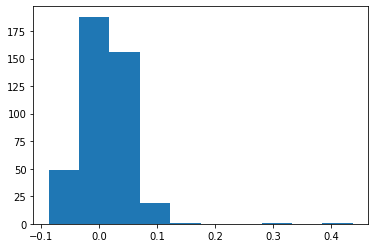

In [16]:
diffs = []
for cell_specimen_id in tqdm(get_cell_specimen_ids(active_experiment)):
    trace_before_stimulus = get_dff_in_interval(cell_dff_dfs[cell_specimen_id], stimulus_start_time-0.25, stimulus_start_time)
    trace_after_stimulus = get_dff_in_interval(cell_dff_dfs[cell_specimen_id], stimulus_start_time, stimulus_start_time+0.25)
    diffs.append(np.mean(trace_after_stimulus) - np.mean(trace_before_stimulus))
plt.hist(diffs);

In [17]:
cell_specimen_ids = get_cell_specimen_ids(active_experiment)
cell_specimen_ids[np.argmax(diffs)]

1086604838

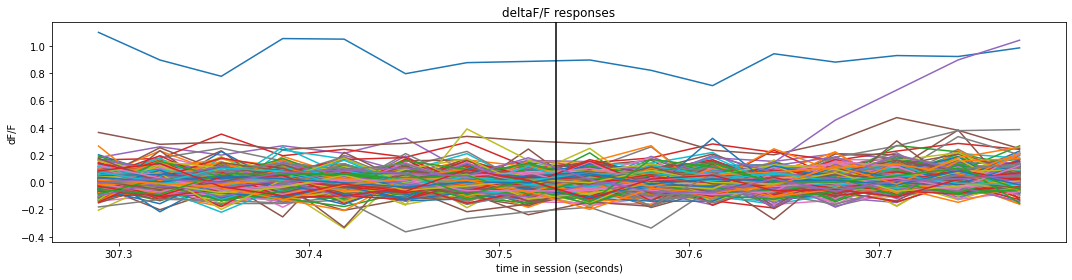

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (15, 4))

trial_dff_traces = dff_df.query('@start_time <= timestamps and timestamps <= @stop_time')

for cell_specimen_id in cell_specimen_ids:
    ax.plot(
        trial_dff_traces.query('cell_specimen_id == @cell_specimen_id')['timestamps'],
        trial_dff_traces.query('cell_specimen_id == @cell_specimen_id')['dff']
    )

ax.axvline(x=stimulus_start_time, color="k", linestyle="-")
ax.set_title('deltaF/F responses')
ax.set_ylabel('dF/F')
ax.set_xlabel('time in session (seconds)')
fig.tight_layout()
fig.show()

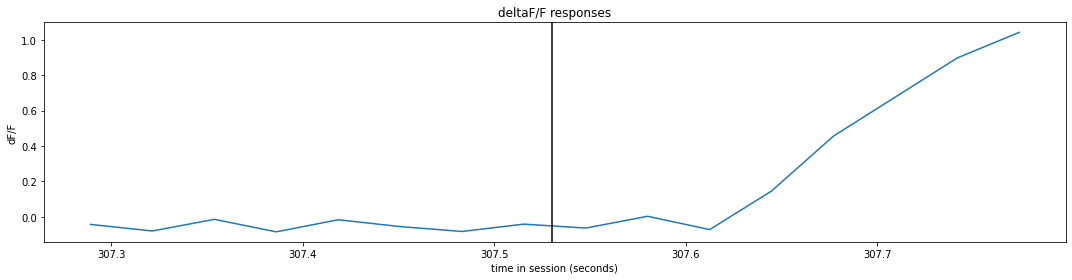

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (15, 4))

trial_dff_traces = dff_df.query('@start_time <= timestamps and timestamps <= @stop_time')

for cell_specimen_id in [1086604838]:
    ax.plot(
        trial_dff_traces.query('cell_specimen_id == @cell_specimen_id')['timestamps'],
        trial_dff_traces.query('cell_specimen_id == @cell_specimen_id')['dff']
    )

ax.axvline(x=stimulus_start_time, color="k", linestyle="-")
ax.set_title('deltaF/F responses')
ax.set_ylabel('dF/F')
ax.set_xlabel('time in session (seconds)')
fig.tight_layout()
fig.show()